<a href="https://colab.research.google.com/github/insancs/image-scene-classification/blob/main/Submission3_Dicoding_Image_Classification1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Configuration

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

# Download Dataset

In [ ]:
! kaggle datasets download puneet6060/intel-image-classification

 95% 328M/346M [00:01<00:00, 234MB/s]
100% 346M/346M [00:01<00:00, 217MB/s]


# Import Library

In [ ]:
from random import randint
import zipfile
import os
import cv2        
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle    

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
print(tf.__version__)

2.5.0


# Extract Dataset

In [ ]:
local_zip = 'intel-image-classification.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
print(os.listdir('/tmp/'))
print(os.listdir('/tmp/seg_train/seg_train'))
print(os.listdir('/tmp/seg_test/seg_test'))

train_dir = '/tmp/seg_train/seg_train'
validation_dir = '/tmp/seg_test/seg_test'

['seg_test', 'initgoogle_syslog_dir.0', 'dap_multiplexer.b12584203b01.root.log.INFO.20210814-094300.53', 'seg_train', 'dap_multiplexer.INFO', 'debugger_24r93yj846', 'seg_pred']
['buildings', 'sea', 'mountain', 'forest', 'street', 'glacier']
['buildings', 'sea', 'mountain', 'forest', 'street', 'glacier']


In [ ]:
# Define Image Loader function
def get_images(directory):
    Images = []
    Labels = []  # 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street
    label = 0
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        if labels == 'glacier': #Folder contain Glacier Images get the '2' class label.
            label = 2
        elif labels == 'sea':
            label = 4
        elif labels == 'buildings':
            label = 0
        elif labels == 'forest':
            label = 1
        elif labels == 'street':
            label = 5
        elif labels == 'mountain':
            label = 3
        
        for image_file in os.listdir(directory + labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory + labels + r'/' + image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(150,150)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images, Labels, random_state=817328462) #Shuffle the dataset you just prepared.

# Define class label function
def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
    
    return labels[class_code]

In [ ]:
#Get the images and labels from the folders.
images, labels = get_images('/tmp/seg_train/seg_train/') 

#converting the list of images to numpy array.
images = np.array(images)
labels = np.array(labels)

# Image Sample

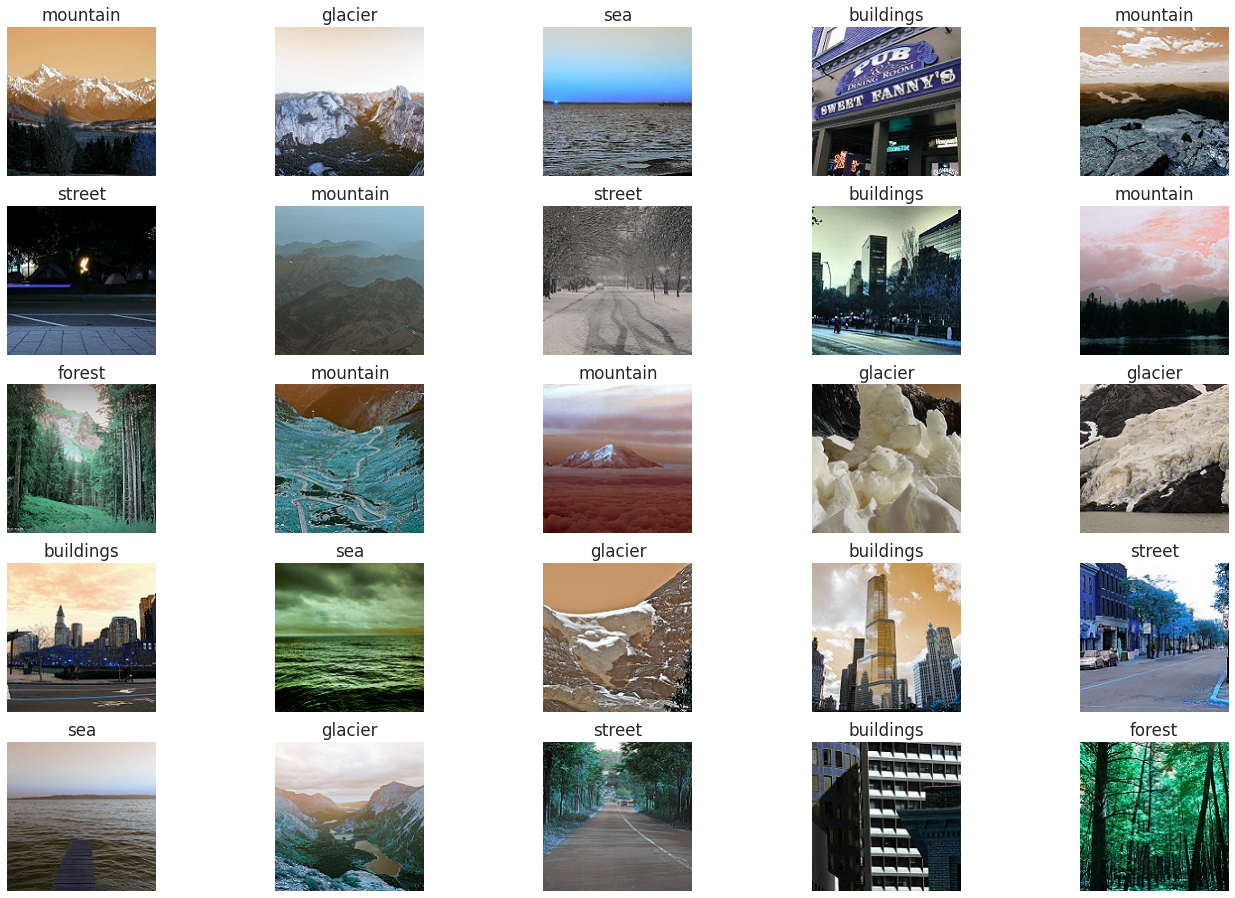

In [ ]:
# Visualize image sample
f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(images))
        ax[i,j].imshow(images[rnd_number])
        ax[i,j].set_title(get_classlabel(labels[rnd_number]))
        ax[i,j].axis('off')

# Image Data Generator

In [ ]:
# Image augmentation
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = 'wrap',
    validation_split = 0.2
)

validation_datagen = ImageDataGenerator(rescale = 1./255,
                                        validation_split = 0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    class_mode = 'categorical',
    batch_size = 64,
    subset = 'training'
)

validation_generator = validation_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    class_mode = 'categorical',
    batch_size = 64,
    subset = 'validation'
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [ ]:
BATCH_SIZE = 64
STEPS_PER_EPOCH = 11230 / BATCH_SIZE

# Build the Model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(64, activation = 'relu'), 
    tf.keras.layers.Dense(6, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0         
_________________________________________________________________
dropout (Dropout)            (None, 82944)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                5

In [ ]:
# count loss function and optimizer
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.optimizers.Adam(),
    metrics = ['accuracy']               
)

## Create Callbacks

In [ ]:
# Define callback
class myCallback(Callback):
    def on_train_begin(self, logs=None):
        print("Starting training")

    def on_train_end(self, logs=None):
        print("Training has been stopped")
        print('Accuracy = %2.2f%%' %(logs['accuracy'] * 100), '\nValidation Accuracy = %2.2f%%' %(logs['val_accuracy'] * 100))

    def on_epoch_begin(self, epoch, logs=None):
        print("Start epoch {} of training".format(epoch + 1))
    
    def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy') > 0.92) and (logs.get('val_accuracy') > 0.92):
        self.model.stop_training = True


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

early_stopping = EarlyStopping(monitor='loss', patience=3)

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    epochs = 50,
                    batch_size = BATCH_SIZE,
                    validation_data = validation_generator,
                    callbacks = [myCallback(), reduce_lr, early_stopping]
                    )

Starting training
Epoch 1/50
Start epoch 1 of training
175/175 [==============================] - 98s 378ms/step - loss: 1.1076 - accuracy: 0.5909 - val_loss: 0.7972 - val_accuracy: 0.7136
Epoch 2/50
Start epoch 2 of training
175/175 [==============================] - 65s 373ms/step - loss: 0.8059 - accuracy: 0.7019 - val_loss: 0.8785 - val_accuracy: 0.7026
Epoch 3/50
Start epoch 3 of training
175/175 [==============================] - 65s 373ms/step - loss: 0.7057 - accuracy: 0.7424 - val_loss: 0.6320 - val_accuracy: 0.7735
Epoch 4/50
Start epoch 4 of training
175/175 [==============================] - 65s 373ms/step - loss: 0.6587 - accuracy: 0.7589 - val_loss: 0.7102 - val_accuracy: 0.7343
Epoch 5/50
Start epoch 5 of training
175/175 [==============================] - 64s 366ms/step - loss: 0.5994 - accuracy: 0.7827 - val_loss: 0.5514 - val_accuracy: 0.8113
Epoch 6/50
Start epoch 6 of training
175/175 [==============================] - 64s 367ms/step - loss: 0.5716 - accuracy: 0.788

# Plotting Accuracy and Loss

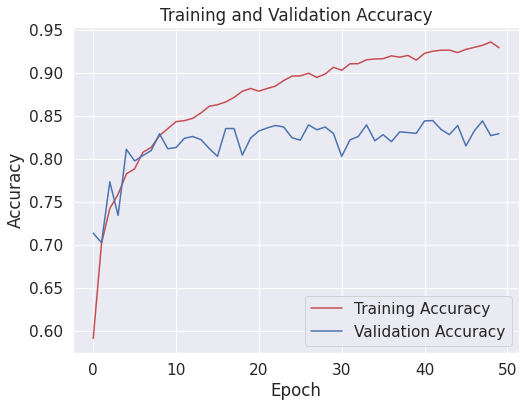

In [ ]:
# Define accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

# Plotting accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

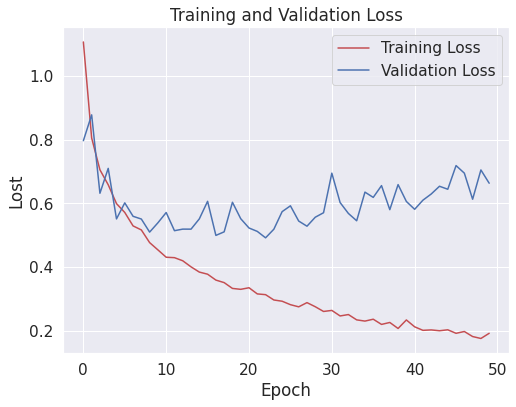

In [ ]:
# Defina loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting loss 
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Lost')
plt.legend(loc='upper right')
plt.grid(False)
plt.show()

# Save the Model to TF-Lite

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpmityk_14/assets


In [ ]:
# Save the model to tf-lite
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)